In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr
import re

In [3]:
import cv2
import numpy as np

numberPlateCascade = cv2.CascadeClassifier('haarcascade_russian_plate_number.xml') 
plat_detector =  cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_russian_plate_number.xml")
img = cv2.imread('data/img.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plates = plat_detector.detectMultiScale(img,scaleFactor=1.2,minNeighbors = 5, minSize=(25,25))   

for (x,y,w,h) in plates:
    cv2.putText(img,text='License Plate',org=(x-3,y-3),fontFace=cv2.FONT_HERSHEY_COMPLEX,color=(0,0,255),thickness=1,fontScale=0.6)
    #img[y:y+h,x:x+w] = cv2.blur(img[y:y+h,x:x+w],ksize=(10,10))
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  

In [4]:
#plt.imshow(img)

In [5]:
from PIL import Image

In [6]:
img1=Image.fromarray(img)

In [7]:
img1.save('new1.jpg')

## 1. Read in Image, Grayscale and Blur

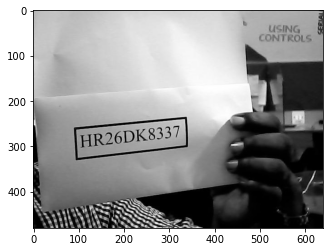

In [8]:
img = cv2.imread('new1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

## 2. Apply filter and find edges for localization

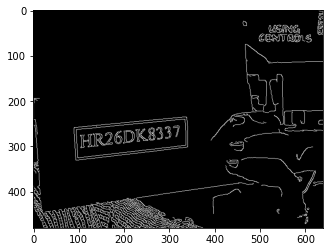

In [9]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

## 3. Find Contours and Apply Mask

In [10]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [11]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 20, True)
    if len(approx) == 4:
        location = approx
        break

In [12]:
location

array([[[339, 236]],

       [[ 91, 258]],

       [[ 94, 330]],

       [[341, 301]]], dtype=int32)

In [13]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

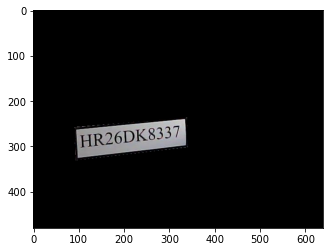

In [14]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [15]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

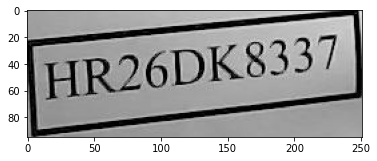

In [16]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

## 4. Use Easy OCR To Read Text

In [17]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[3.9514461957515383, 31.036880054477],
   [237.81572019221773, 8.655069135506762],
   [240.04855380424846, 51.963119945523],
   [6.18427980778228, 73.34493086449324]],
  'HRZ6DK8337',
  0.7509913810758435)]

## 5. Render Result

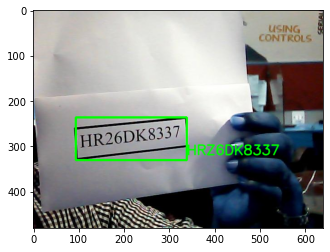

In [18]:
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

In [19]:
#type(text)

In [20]:
print(text)

HRZ6DK8337


In [21]:
text = "".join(re.split("[^a-zA-Z0-9]*", text))

In [22]:
text

'HRZ6DK8337'

In [29]:
import serial
import time
ser = serial.Serial()
ser.port = 'COM3'
ser.baudrate = 9600
ser.bytesize = 8
ser.parity = serial.PARITY_NONE
ser.stopbits = serial.STOPBITS_ONE
ser.open()
a = b'*R#'
ser.write(a)
time.sleep(5)
if text == 'HRZ6DK8337':
    v=b'*1#'
    ser.write(v)
else:
    v=b'*2#'
    ser.write(v)